# PreProcessing and Pipelines

This notebook will house preprocessing pipelines for the Boston Homes data. This will handle skewness, distribution shape, and scaling of the data. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, PowerTransformer 
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, QuantileTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import shap



# Preprocessing Pipelines

Let's establish some Preprocessing pipelines.

First, turn into guassian distribution by transforming with powertransformer, quantile
then apply Standard Scaler
then fix outliers with z-score fixing.


In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = pd.DataFrame(data['data'], columns = data.feature_names), pd.Series(data['target'], name='MEDV')
X.head()
print(y.head())

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64


In [4]:
X.head(10)

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147   54.2  6.0622  3.0  222.0   
5  0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622  3.0  222.0   
6  0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605  5.0  311.0   
7  0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505  5.0  311.0   
8  0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821  5.0  311.0   
9  0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921  5.0  311.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  
5     18.7  394.12   5.21  
6     15.2  395.60  12.43  
7     15.2  396.90  19.15  
8     15.2  386.63  29.93  
9     15.2  386.71  17.10

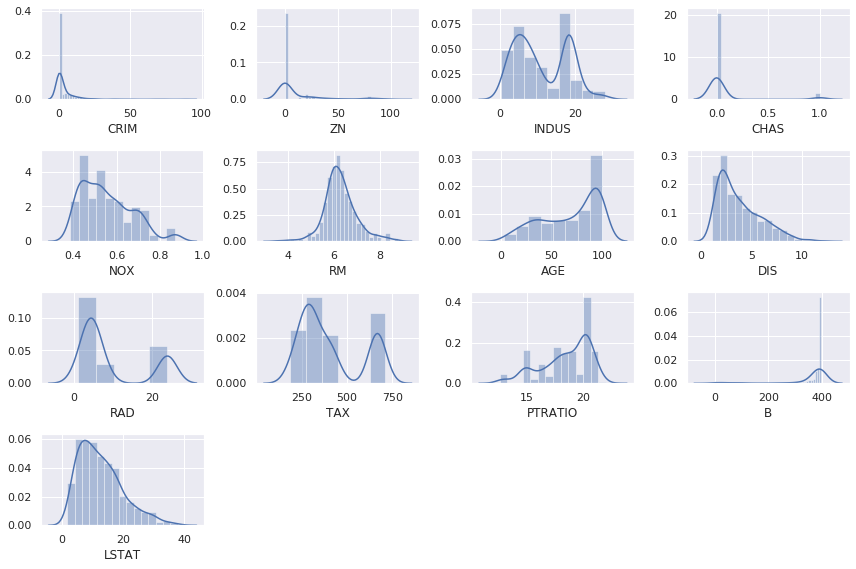

In [5]:
#custom function to display all features histogram shapes and kde shape overlay

def plot_hist(df, features, subplot_dimensions):
    '''Input: list of feature names, list of subplot dimensions'''
    fig = plt.figure(figsize = (12, 8))
    
    for idx, feature in enumerate(list(df[features])):
        idx += 1
        plt.subplot(subplot_dimensions[0], subplot_dimensions[1], idx)
        sns.distplot(df[feature])
        idx +=1
        
        plt.tight_layout()

plot_hist(X, list(X.columns), [4,4])  

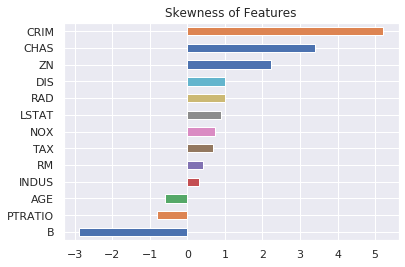

In [6]:
X.skew().sort_values(ascending=True).plot(kind = 'barh', title = "Skewness of Features")

## Baseline Classifier

Here, we'll build a plain random forest regressor to build some baseline results.


In [7]:
#custom scoring function

def score(data, target):
    
    mse_scores = []
    r2_scores = []
    for random_state in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .25, random_state = random_state)
        reg_rf = RandomForestRegressor()
    
        reg_rf.fit(X_train, y_train)
        y_pred = reg_rf.predict(X_test)
    
        score = mean_squared_error(y_test, y_pred)
        mse_scores.append(score)
        
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)


    rmse_scores = [np.sqrt(score) for score in mse_scores]
    print(f" Average Test RMSE: {np.mean(rmse_scores)}")
    print(f" Average Test R^2 Score: {np.mean(r2_scores)}")
    print()
    print(f"RMSE scores: {np.round(rmse_scores,4)}")
    print(f"R^2 scores: {np.round(r2_scores, 3)}")
    
    
score(X, y)

 Average Test RMSE: 3.6457690883864897
 Average Test R^2 Score: 0.842660787634436

RMSE scores: [4.3634 3.6306 3.6178 3.0012 3.877  3.1748 2.9474 4.081  4.1427 3.6218]
R^2 scores: [0.767 0.867 0.853 0.889 0.85  0.878 0.899 0.784 0.787 0.853]


## Feature Transformations

Next, we'll massage our data to improve skewness of some features. We will fix CRIM, ZN, and B, as these continuous features have the highest skew values.

In [8]:
#first, create a copy of data to do manipulations on

X_copy = X.copy()

for col in ['CRIM', 'ZN', 'B']:
    if col == 'ZN':
        X_copy[col] += 1
        X_copy[col] = np.log(X_copy[col])
    elif col == 'B':
        X_copy[col] = np.sqrt(X_copy[col])
    else:
        X_copy[col] = np.log(X_copy[col])
X_copy.head()

CRIM        ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0 -5.064036  2.944439   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1 -3.600502  0.000000   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2 -3.601235  0.000000   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3 -3.430523  0.000000   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4 -2.672924  0.000000   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO          B  LSTAT  
0     15.3  19.922349   4.98  
1     17.8  19.922349   9.14  
2     17.8  19.819939   4.03  
3     18.7  19.865296   2.94  
4     18.7  19.922349   5.33

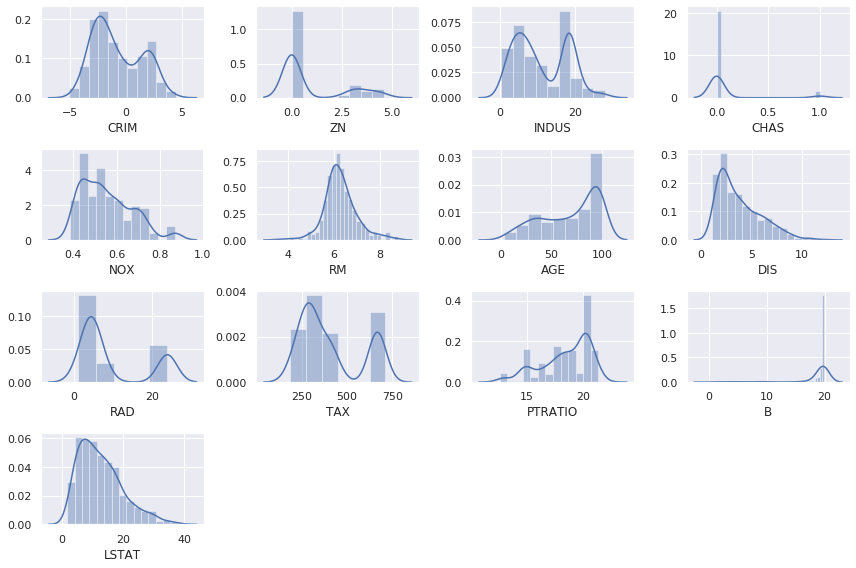

In [9]:
plot_hist(X_copy, list(X_copy.columns), [4,4])


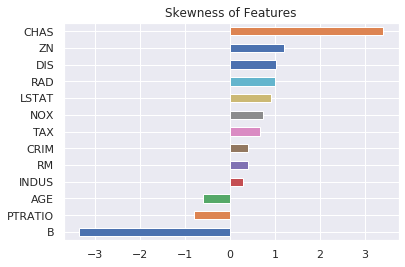

In [10]:
X_copy.skew().sort_values(ascending=True).plot(kind = 'barh', title = "Skewness of Features")

In [11]:
score(X_copy, y)

 Average Test RMSE: 3.6114517334689764
 Average Test R^2 Score: 0.8447783397437757

RMSE scores: [4.3503 3.0049 3.4475 3.3231 3.9811 2.9238 3.1849 4.1709 4.0048 3.723 ]
R^2 scores: [0.768 0.909 0.866 0.864 0.842 0.896 0.882 0.774 0.801 0.844]


A very slight improvement in the RMSE results, very small change in R^2 results. 

For now, we'll implement interpretability libraries here.

Start with LIME.

First, set up the random forest regressor. We'll fit it to a training split of the original data, not the manipulated data, and then get predictions. We'll use the original data for illustrative purposes, so we can use the actual values of all features.

## Interpretaton

In [12]:
import lime
import lime.lime_tabular as lt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)
reg_rf = RandomForestRegressor()

reg_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
#get predictions
y_pred = reg_rf.predict(X_test)

Now, we need to establish an 'explainer' object that will eventually explain some of our model's predictions. 

In [14]:
#also build a predict_proba

explainer = lt.LimeTabularExplainer(X_train.values, mode = 'regression', feature_names=list(X_train.columns), class_names = 'MEDV',)


In [15]:
#show 3 seperate examples, 
for i in [10, 20, 30]:
    print(f"Actual Value: {y_test.values[i]}")
    exp = explainer.explain_instance(X_test.values[i], predict_fn=reg_rf.predict, num_features=5)
    exp.show_in_notebook(show_predicted_value=True)
    

Actual Value: 23.7


Actual Value: 16.2


Actual Value: 24.1


Analysis: We have the predicted value for an example, the actual feature values for that particular example, and the feature-value pair that mimics contribution to prediction. On the last instance, since LSTAT is <= 7.17, this particular home is "7.46 more expensive", on average. In another way, if this house did not have LSTAT <= 7.17, this house would be on average "7.46 less expensive". 


Now let's turn to SHAP and examine its capabilities. 

First, need to initialize Javascript plotting in the notebook. Then, build an explainer and calculate all shap values on a particular dataset we pass it. 

In [16]:
shap.initjs()

explainer_shap = shap.TreeExplainer(reg_rf)
shap_values = explainer_shap.shap_values(X_test)

Build a force plot which can show, for an individual example, how feature-value combinations affect model output. Below, the model's predicton is 28.43, and the average prediction on the dataset the model was trained on is the 'base vale', of 22.25.  The features-values in red are contributing to the model prediction higher than the base value, and the feature-values in blue are contributing to the model predicting lower than the base value. 

In [17]:
i = 10
shap.force_plot(explainer_shap.expected_value, shap_values[i,:], X_test.iloc[i,:])


If we combine all such force plots for all instances, we can build a wholistic force plot for the entire dataset. 

In [18]:
shap.force_plot(explainer_shap.expected_value, shap_values, X_test)

SHAP can also score feature importances for the entire dataset. 

In the chart below, there are two main elements: first is the ordering of the featues on the left y-axis. This ordering indicates the ranking of important features; LSTAT is scored as the most important feature. The second element is the color and horizontal placement on the grid. For an individual feature, a single dot represents a single instance in the dataset. The color indicates the feature value; closer to red is a higher value, and a color closer to blue is a lower value. Where it is placed shows the SHAP value of that particular example's feature value; those examples below 0 have a negative SHAP value, so they contribute to the model predicting lower than the base value, and vice-versa.

For instance, the chart shows that a higher value for RM contributes to higher predicted home prices.  

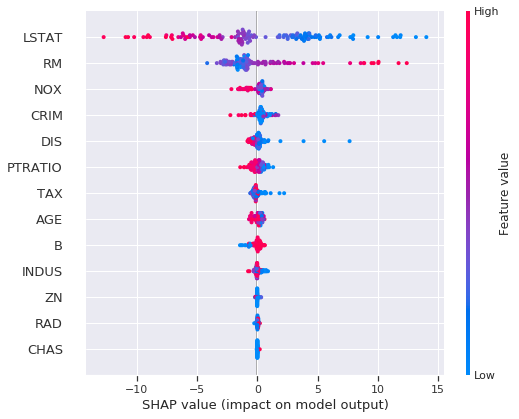

In [19]:
shap.summary_plot(shap_values, X_test)